In [ ]:
!pip install transformers

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to your file on Google Drive
file_path = "/content/drive/My Drive/merged_tensors_with_labels.csv"

# Copy the file to Colab under the /content directory
!cp "{file_path}" /content

# Load the CSV file into a DataFrame
import pandas as pd
df = pd.read_csv("/content/merged_tensors_with_labels.csv")

# Display the DataFrame
print(df.head())

Mounted at /content/drive
          0         1         2         3         4         5         6  \
0 -0.788955 -0.452171 -0.718902  0.524362  0.407345 -0.054561  0.599061   
1 -0.786391 -0.536763 -0.928366  0.635211  0.677996 -0.164220  0.391323   
2 -0.760979 -0.356124 -0.678704  0.650039  0.453287 -0.208375  0.471421   
3 -0.645143 -0.442135 -0.855603  0.572795  0.629087 -0.262791  0.218573   
4 -0.715979 -0.244338 -0.451217  0.467052  0.265069 -0.223246 -0.013612   

          7         8         9  ...       759       760       761       762  \
0  0.322636 -0.314898 -0.999944  ...  0.029673  0.846054  0.820441  0.263943   
1  0.416578 -0.727519 -0.999947  ... -0.129403  0.900940  0.696012  0.549645   
2  0.159647 -0.395316 -0.999743  ...  0.439547  0.853939  0.784838  0.883011   
3  0.249878 -0.622201 -0.999599  ...  0.541194  0.944661  0.662793  0.681176   
4  0.125522 -0.200415 -0.999057  ...  0.191682  0.713078  0.695555  0.938667   

        763       764       765       766 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1], Train Loss: 0.4086, Test Loss: 0.3322, Train Accuracy: 81.50%, Test Accuracy: 86.36%
Epoch [2], Train Loss: 0.2871, Test Loss: 0.2615, Train Accuracy: 88.44%, Test Accuracy: 89.53%
Epoch [3], Train Loss: 0.2474, Test Loss: 0.2919, Train Accuracy: 89.72%, Test Accuracy: 88.24%
Epoch [4], Train Loss: 0.2288, Test Loss: 0.2220, Train Accuracy: 90.38%, Test Accuracy: 91.01%
Epoch [5], Train Loss: 0.2069, Test Loss: 0.2044, Train Accuracy: 91.67%, Test Accuracy: 91.98%
Epoch [6], Train Loss: 0.1981, Test Loss: 0.1936, Train Accuracy: 92.35%, Test Accuracy: 92.24%
Epoch [7], Train Loss: 0.1914, Test Loss: 0.1882, Train Accuracy: 92.71%, Test Accuracy: 92.24%
Epoch [8], Train Loss: 0.1962, Test Loss: 0.2142, Train Accuracy: 92.59%, Test Accuracy: 91.27%
Epoch [9], Train Loss: 0.1874, Test Loss: 0.1863, Train Accuracy: 92.35%, Test Accuracy: 92.37%
Epoch [10], Train Loss: 0.1782, Test Loss: 0.1719, Train Accuracy: 92.90%, Test Accuracy: 92.70%
Epoch [11], Train Loss: 0.1727, Test Lo

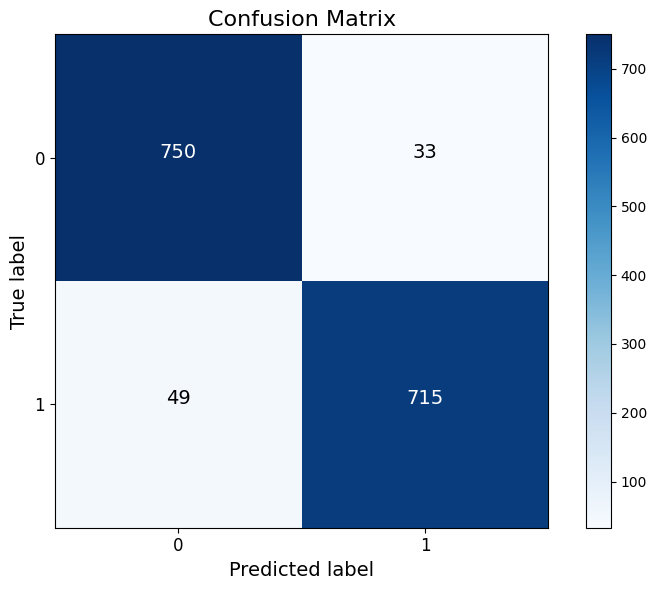

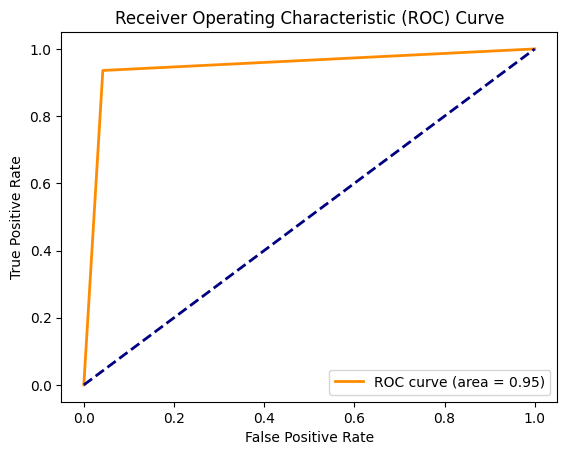

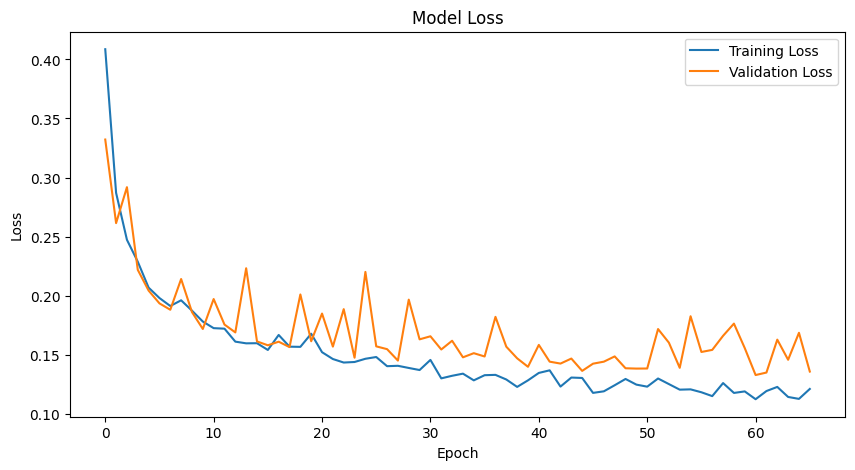

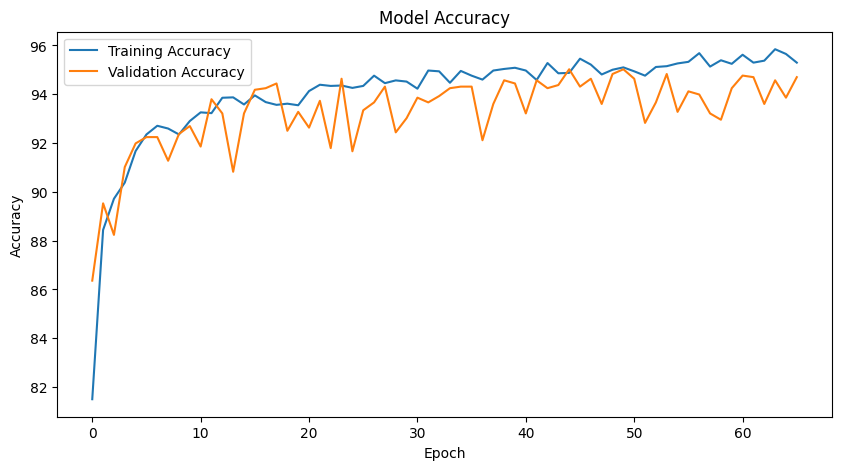

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import matplotlib.pyplot as plt
import itertools

# Load the encoded data
df = pd.read_csv("/content/merged_tensors_with_labels.csv")

# Extract features and labels
features = df.drop(columns=['is_depression']).values
labels = df['is_depression'].values

# Split the dataset into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Define data loaders
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleClassifier(input_size=train_features.shape[1], hidden_size=64, output_size=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Early stopping with patience 20 for validation loss
early_stopping = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, threshold=0.0001, mode='min', verbose=True)

# Train the model
best_accuracy = 0
best_epoch = 0
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
epoch = 0
patience = 20
min_loss = np.Inf

while epoch - best_epoch <= patience:
    epoch += 1
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        predictions = []
        true_labels = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    # Update best accuracy and epoch if needed
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_epoch = epoch

    # Apply learning rate scheduler
    early_stopping.step(test_loss)

    # Check for early stopping
    if early_stopping._last_lr[0] <= early_stopping.eps:
        print(f"Early stopping at Epoch [{epoch}]")
        break

    # Print accuracy and loss for each epoch
    print(f"Epoch [{epoch}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Accuracy: {test_accuracies[-1]:.2f}%")

# Print best accuracy and epoch
print(f"Best Test Accuracy: {best_accuracy:.2f}% at Epoch {best_epoch}")

# Generate classification report
print("Final Classification Report:")
print(classification_report(true_labels, predictions))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=16)  # Increase title font size
plt.colorbar()
classes = [0, 1]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, fontsize=12)  # Increase x-axis tick font size
plt.yticks(tick_marks, classes, fontsize=12)  # Increase y-axis tick font size
plt.xlabel('Predicted label', fontsize=14)  # Increase x-axis label font size
plt.ylabel('True label', fontsize=14)  # Increase y-axis label font size
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black",
             fontsize=14)  # Increase text font size
plt.tight_layout()
plt.show()

# Generate and plot ROC curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv("/content/merged_tensors_with_labels.csv")

# Remove the column containing labels ('is_depression')
df_without_labels = df.drop(columns=['is_depression'])

# Save the DataFrame without labels to a new CSV file
df_without_labels.to_csv("/content/merged_tensors_without_labels.csv", index=False)


Epoch [1/50], Train Loss: 0.0571
Epoch [2/50], Train Loss: 0.0085
Epoch [3/50], Train Loss: 0.0070
Epoch [4/50], Train Loss: 0.0061
Epoch [5/50], Train Loss: 0.0054
Epoch [6/50], Train Loss: 0.0048
Epoch [7/50], Train Loss: 0.0042
Epoch [8/50], Train Loss: 0.0039
Epoch [9/50], Train Loss: 0.0036
Epoch [10/50], Train Loss: 0.0034
Epoch [11/50], Train Loss: 0.0033
Epoch [12/50], Train Loss: 0.0030
Epoch [13/50], Train Loss: 0.0029
Epoch [14/50], Train Loss: 0.0029
Epoch [15/50], Train Loss: 0.0026
Epoch [16/50], Train Loss: 0.0026
Epoch [17/50], Train Loss: 0.0025
Epoch [18/50], Train Loss: 0.0024
Epoch [19/50], Train Loss: 0.0024
Epoch [20/50], Train Loss: 0.0022
Epoch [21/50], Train Loss: 0.0022
Epoch [22/50], Train Loss: 0.0022
Epoch [23/50], Train Loss: 0.0020
Epoch [24/50], Train Loss: 0.0020
Epoch [25/50], Train Loss: 0.0020
Epoch [26/50], Train Loss: 0.0020
Epoch [27/50], Train Loss: 0.0018
Epoch [28/50], Train Loss: 0.0019
Epoch [29/50], Train Loss: 0.0019
Epoch [30/50], Train Lo

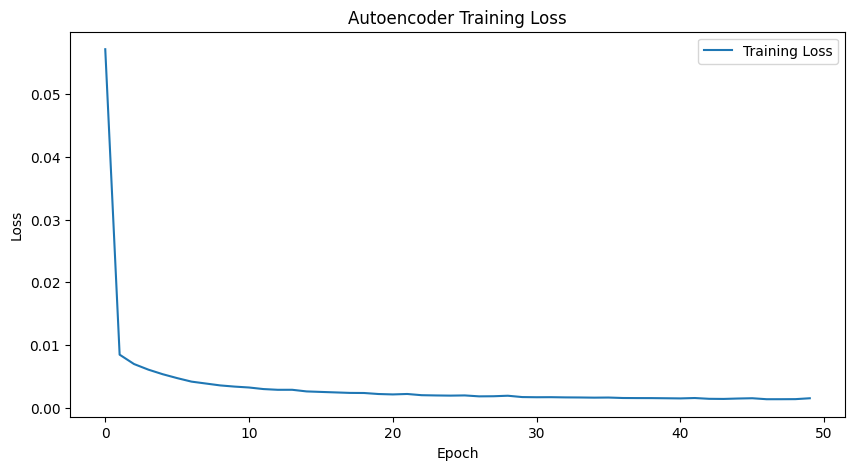

Average Loss over 50 epochs: 0.0036


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import matplotlib.pyplot as plt

# Load the encoded data
df = pd.read_csv("/content/merged_tensors_with_labels.csv")

# Remove the target variable ('is_depression')
features_only = df.drop(columns=['is_depression'])

# Extract features
features = features_only.values

# Split the dataset into training and testing sets
train_features, test_features = train_test_split(features, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)

# Define data loaders
train_loader = DataLoader(train_features_tensor, batch_size=64, shuffle=True)
test_loader = DataLoader(test_features_tensor, batch_size=64, shuffle=False)

# Define the model
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleAutoencoder(input_size=features.shape[1], hidden_size=64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the autoencoder
train_losses = []
for epoch in range(50):
    model.train()
    train_loss = 0.0
    for inputs in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{50}], Train Loss: {train_losses[-1]:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Average loss over epochs
average_loss = np.mean(train_losses)
print(f"Average Loss over {len(train_losses)} epochs: {average_loss:.4f}")


Epoch [1/50], Train Loss: 0.0559, Val Loss: 0.0113
Epoch [2/50], Train Loss: 0.0088, Val Loss: 0.0075
Epoch [3/50], Train Loss: 0.0070, Val Loss: 0.0064
Epoch [4/50], Train Loss: 0.0060, Val Loss: 0.0056
Epoch [5/50], Train Loss: 0.0052, Val Loss: 0.0049
Epoch [6/50], Train Loss: 0.0047, Val Loss: 0.0043
Epoch [7/50], Train Loss: 0.0042, Val Loss: 0.0040
Epoch [8/50], Train Loss: 0.0038, Val Loss: 0.0037
Epoch [9/50], Train Loss: 0.0036, Val Loss: 0.0035
Epoch [10/50], Train Loss: 0.0033, Val Loss: 0.0033
Epoch [11/50], Train Loss: 0.0032, Val Loss: 0.0031
Epoch [12/50], Train Loss: 0.0030, Val Loss: 0.0029
Epoch [13/50], Train Loss: 0.0029, Val Loss: 0.0028
Epoch [14/50], Train Loss: 0.0027, Val Loss: 0.0027
Epoch [15/50], Train Loss: 0.0027, Val Loss: 0.0027
Epoch [16/50], Train Loss: 0.0025, Val Loss: 0.0028
Epoch [17/50], Train Loss: 0.0025, Val Loss: 0.0024
Epoch [18/50], Train Loss: 0.0023, Val Loss: 0.0023
Epoch [19/50], Train Loss: 0.0023, Val Loss: 0.0023
Epoch [20/50], Train 

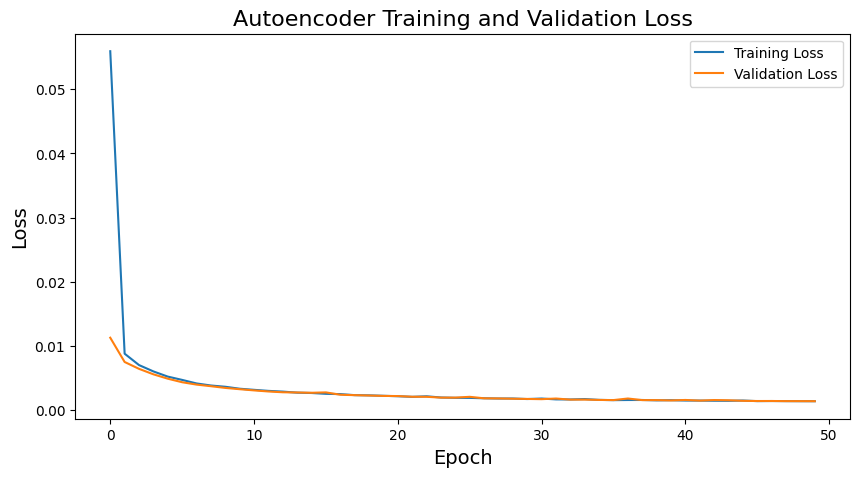

Average Training Loss over 50 epochs: 0.0036
Average Validation Loss over 50 epochs: 0.0026


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import matplotlib.pyplot as plt

# Load the encoded data
df = pd.read_csv("/content/merged_tensors_with_labels.csv")

# Remove the target variable ('is_depression')
features_only = df.drop(columns=['is_depression'])

# Convert data to PyTorch tensors
features = features_only.values
features_tensor = torch.tensor(features, dtype=torch.float32)

# Split the dataset into training and testing sets
train_features, test_features = train_test_split(features_tensor, test_size=0.2, random_state=42)

# Define data loaders
train_loader = DataLoader(train_features, batch_size=64, shuffle=True)
test_loader = DataLoader(test_features, batch_size=64, shuffle=False)

# Define the model
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleAutoencoder(input_size=features.shape[1], hidden_size=64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the autoencoder
train_losses = []
val_losses = []
for epoch in range(50):
    model.train()
    train_loss = 0.0
    for inputs in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/{50}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Autoencoder Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.show()

# Average loss over epochs
average_loss = np.mean(train_losses)
print(f"Average Training Loss over {len(train_losses)} epochs: {average_loss:.4f}")

average_val_loss = np.mean(val_losses)
print(f"Average Validation Loss over {len(val_losses)} epochs: {average_val_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1], Train Loss: 0.3911, Test Loss: 0.3379, Train Accuracy: 82.63%, Test Accuracy: 86.43%
Epoch [2], Train Loss: 0.2748, Test Loss: 0.2637, Train Accuracy: 88.50%, Test Accuracy: 89.59%
Epoch [3], Train Loss: 0.2419, Test Loss: 0.2246, Train Accuracy: 90.14%, Test Accuracy: 91.01%
Epoch [4], Train Loss: 0.2168, Test Loss: 0.2548, Train Accuracy: 91.40%, Test Accuracy: 89.27%
Epoch [5], Train Loss: 0.2072, Test Loss: 0.2068, Train Accuracy: 91.61%, Test Accuracy: 92.05%
Epoch [6], Train Loss: 0.1943, Test Loss: 0.1943, Train Accuracy: 92.21%, Test Accuracy: 92.24%
Epoch [7], Train Loss: 0.2038, Test Loss: 0.1833, Train Accuracy: 91.72%, Test Accuracy: 92.63%
Epoch [8], Train Loss: 0.2075, Test Loss: 0.1802, Train Accuracy: 91.66%, Test Accuracy: 92.44%
Epoch [9], Train Loss: 0.1800, Test Loss: 0.2101, Train Accuracy: 92.97%, Test Accuracy: 91.86%
Epoch [10], Train Loss: 0.1746, Test Loss: 0.1800, Train Accuracy: 93.01%, Test Accuracy: 93.28%
Epoch [11], Train Loss: 0.1664, Test Lo

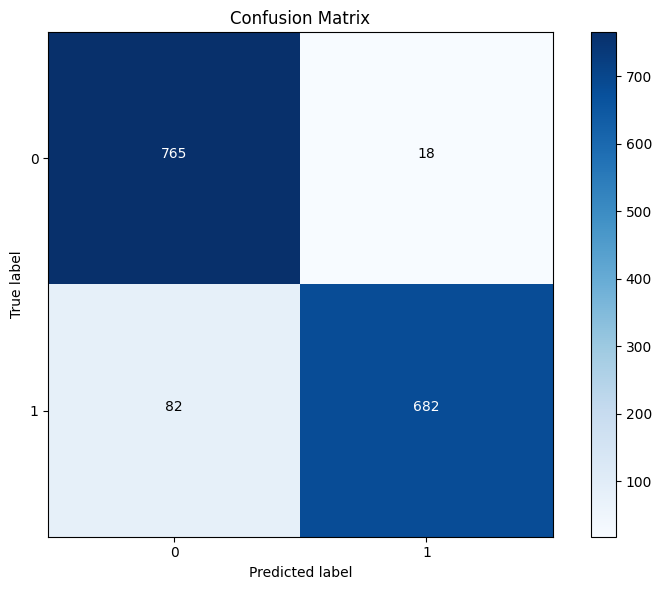

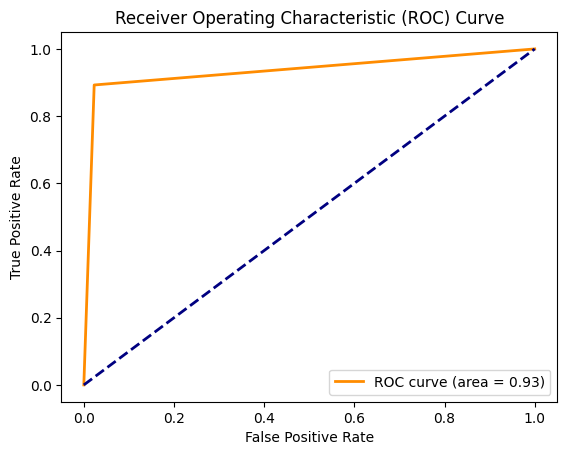

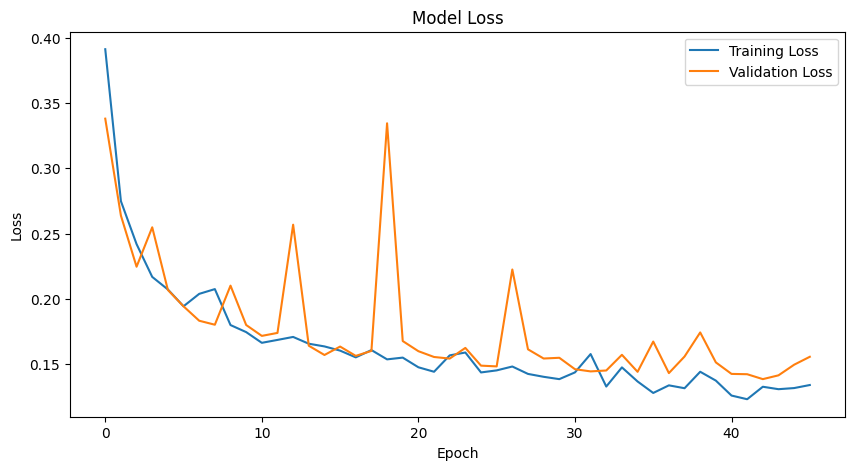

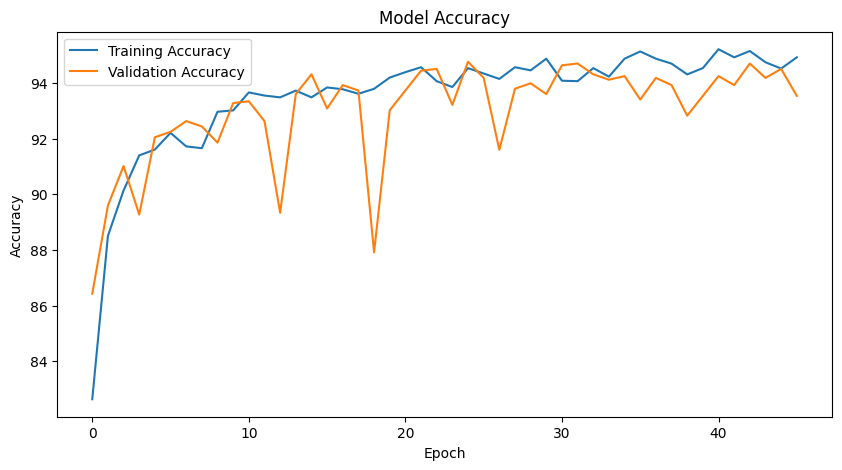

Average Validation Loss: 0.1775
Average Validation Accuracy: 93.01%


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import matplotlib.pyplot as plt
import itertools

# Load the encoded data
df = pd.read_csv("/content/merged_tensors_with_labels.csv")

# Extract features and labels
features = df.drop(columns=['is_depression']).values
labels = df['is_depression'].values

# Split the dataset into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Define data loaders
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleClassifier(input_size=train_features.shape[1], hidden_size=64, output_size=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Early stopping with patience 20 for validation loss
early_stopping = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, threshold=0.0001, mode='min', verbose=True)

# Train the model
best_accuracy = 0
best_epoch = 0
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
epoch = 0
patience = 20
min_loss = np.Inf

while epoch - best_epoch <= patience:
    epoch += 1
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        predictions = []
        true_labels = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    # Update best accuracy and epoch if needed
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_epoch = epoch

    # Apply learning rate scheduler
    early_stopping.step(test_loss)

    # Check for early stopping
    if early_stopping._last_lr[0] <= early_stopping.eps:
        print(f"Early stopping at Epoch [{epoch}]")
        break

    # Print accuracy and loss for each epoch
    print(f"Epoch [{epoch}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Accuracy: {test_accuracies[-1]:.2f}%")

# Print best accuracy and epoch
print(f"Best Test Accuracy: {best_accuracy:.2f}% at Epoch {best_epoch}")

# Generate classification report
print("Final Classification Report:")
print(classification_report(true_labels, predictions))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = [0, 1]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# Generate and plot ROC curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate average validation loss
avg_validation_loss = sum(test_losses) / len(test_losses)

# Calculate average validation accuracy
avg_validation_accuracy = sum(test_accuracies) / len(test_accuracies)

print(f"Average Validation Loss: {avg_validation_loss:.4f}")
print(f"Average Validation Accuracy: {avg_validation_accuracy:.2f}%")


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/depression_dataset_reddit_cleaned.csv')

# Display the first few rows along with text and encoded features
print(df.head())


                                          clean_text  is_depression
0  we understand that most people who reply immed...              1
1  welcome to r depression s check in post a plac...              1
2  anyone else instead of sleeping more when depr...              1
3  i ve kind of stuffed around a lot in my life d...              1
4  sleep is my greatest and most comforting escap...              1


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Reshape
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Load the CSV file
df = pd.read_csv('/content/depression_dataset_reddit_cleaned.csv')

# Preprocess the text data
max_words = 10000  # Maximum number of words to tokenize
max_len = 100      # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(sequences, maxlen=max_len)

# Define the autoencoder model
input_dim = X.shape[1]
encoding_dim = 32  # Adjust this as needed

input_text = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_text)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_text, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Split the data into train and test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_test, X_test))

# Get the encoded features
encoder = Model(input_text, encoded)
encoded_features = encoder.predict(X)

# Add the encoded features to the DataFrame
encoded_features_df = pd.DataFrame(encoded_features, columns=[f'encoded_feature_{i}' for i in range(encoding_dim)])
df_with_encoded_features = pd.concat([df, encoded_features_df], axis=1)

# Display the DataFrame with encoded features
print(df_with_encoded_features.head())


Epoch 1/10
194/194 [==============================] - 2s 4ms/step - loss: -1326988.6250 - val_loss: -5300673.0000
Epoch 2/10
194/194 [==============================] - 1s 4ms/step - loss: -18811130.0000 - val_loss: -33797308.0000
Epoch 3/10
194/194 [==============================] - 1s 5ms/step - loss: -58575112.0000 - val_loss: -79985144.0000
Epoch 4/10
194/194 [==============================] - 1s 5ms/step - loss: -115254296.0000 - val_loss: -142638864.0000
Epoch 5/10
194/194 [==============================] - 1s 4ms/step - loss: -188773296.0000 - val_loss: -219338768.0000
Epoch 6/10
194/194 [==============================] - 1s 4ms/step - loss: -278297248.0000 - val_loss: -311364256.0000
Epoch 7/10
194/194 [==============================] - 1s 5ms/step - loss: -382911744.0000 - val_loss: -416772576.0000
Epoch 8/10
194/194 [==============================] - 1s 3ms/step - loss: -497211808.0000 - val_loss: -530888832.0000
Epoch 9/10
194/194 [==============================] - 1s 3ms/ste

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

# Load the CSV file
df = pd.read_csv('/content/depression_dataset_reddit_cleaned.csv')

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['clean_text'], df['is_depression'], test_size=0.2, random_state=42)

# Encoding text data using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Define the autoencoder model
autoencoder = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(X_train_tfidf.shape[1], activation='sigmoid')  # Output layer
])

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder model
autoencoder.fit(X_train_tfidf, X_train_tfidf, epochs=10, batch_size=64, validation_data=(X_val_tfidf, X_val_tfidf))

# Extracting encoded features
encoder = Sequential(autoencoder.layers[:3])  # Extract encoder layers
X_train_encoded = encoder.predict(X_train_tfidf)
X_val_encoded = encoder.predict(X_val_tfidf)

# Define the classifier model
classifier = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_encoded.shape[1],)),
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the classifier model
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the classifier model using encoded features
history = classifier.fit(X_train_encoded, y_train, validation_data=(X_val_encoded, y_val), epochs=50, batch_size=64)

# Evaluation
evaluation = classifier.evaluate(X_val_encoded, y_val)
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])


Train on 6184 samples, validate on 1547 samples
Epoch 1/10
6184/6184 [==============================] - ETA: 0s - loss: 0.1562

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6184/6184 [==============================] - 12s 2ms/sample - loss: 0.1562 - val_loss: 0.0090
Epoch 2/10
6184/6184 [==============================] - 5s 808us/sample - loss: 0.0077 - val_loss: 0.0066
Epoch 3/10
6184/6184 [==============================] - 7s 1ms/sample - loss: 0.0063 - val_loss: 0.0062
Epoch 4/10
6184/6184 [==============================] - 5s 791us/sample - loss: 0.0062 - val_loss: 0.0061
Epoch 5/10
6184/6184 [==============================] - 5s 795us/sample - loss: 0.0061 - val_loss: 0.0061
Epoch 6/10
6184/6184 [==============================] - 8s 1ms/sample - loss: 0.0061 - val_loss: 0.0061
Epoch 7/10
6184/6184 [==============================] - 5s 793us/sample - loss: 0.0061 - val_loss: 0.0061
Epoch 8/10
6184/6184 [==============================] - 5s 867us/sample - loss: 0.0061 - val_loss: 0.0061
Epoch 9/10
6184/6184 [==============================] - 6s 934us/sample - loss: 0.0061 - val_loss: 0.0061
Epoch 10/10
6184/6184 [==============================] - 5s 77

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 6184 samples, validate on 1547 samples
Epoch 1/50
6184/6184 [==============================] - 1s 109us/sample - loss: 0.6846 - accuracy: 0.5493 - val_loss: 0.6637 - val_accuracy: 0.5656
Epoch 2/50
6184/6184 [==============================] - 0s 51us/sample - loss: 0.6481 - accuracy: 0.7088 - val_loss: 0.6232 - val_accuracy: 0.7266
Epoch 3/50
6184/6184 [==============================] - 0s 54us/sample - loss: 0.6073 - accuracy: 0.7382 - val_loss: 0.5825 - val_accuracy: 0.7434
Epoch 4/50
6184/6184 [==============================] - 0s 54us/sample - loss: 0.5723 - accuracy: 0.7418 - val_loss: 0.5433 - val_accuracy: 0.7744
Epoch 5/50
6184/6184 [==============================] - 0s 54us/sample - loss: 0.5374 - accuracy: 0.7621 - val_loss: 0.5264 - val_accuracy: 0.7304
Epoch 6/50
6184/6184 [==============================] - 0s 46us/sample - loss: 0.5188 - accuracy: 0.7699 - val_loss: 0.5005 - val_accuracy: 0.7602
Epoch 7/50
6184/6184 [==============================] - 0s 51us/sampl

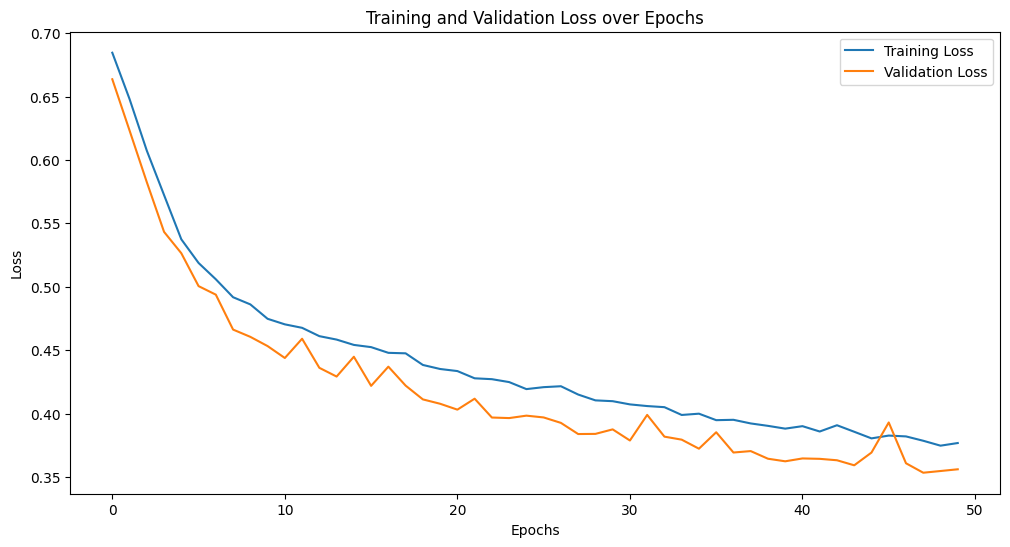

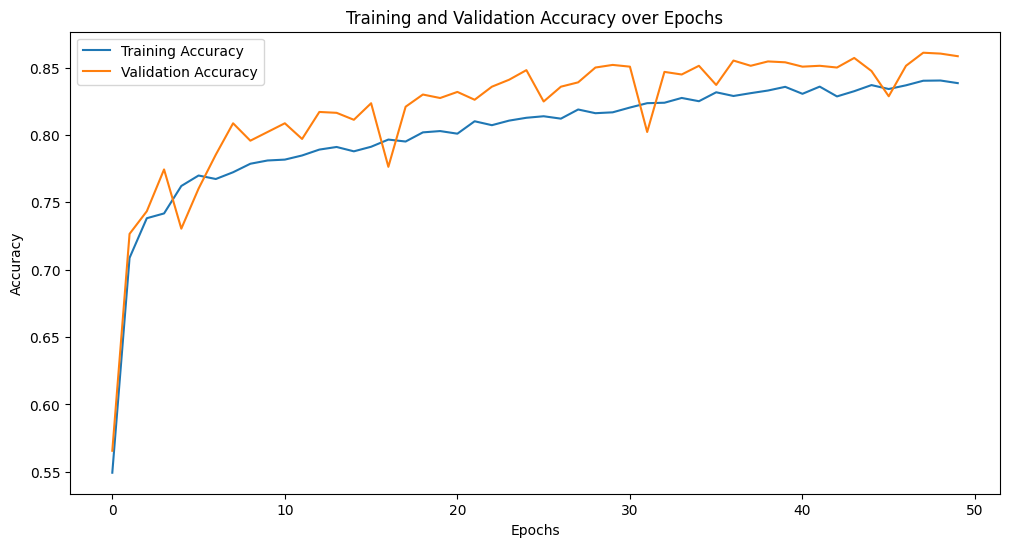

In [ ]:
import matplotlib.pyplot as plt

# Extracting training and validation loss and accuracy from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy over epochs
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
